In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
dataset_path = "/content/drive/My Drive/capstone_dataset"
os.listdir(dataset_path)

['ALL_DOWN_SYNDROME_IMAGES',
 'Autism_Images',
 'Deletion_syndrome',
 'down_predict.jpg',
 'down_preprocessed_dataset',
 'healthy_preprocessed_dataset',
 'split_dataset',
 'healthy.jpg',
 'features.npy',
 'features_filenames.npy',
 'models',
 'front.jpg',
 'down_46.jpg',
 'deletion_preprocessed_dataset',
 'classification_summary.csv',
 'deletion_split_dataset',
 'healthy_split_dataset',
 'misclassified_images.csv']

In [ ]:
!ls "/content/drive/My Drive/capstone_dataset"


ALL_DOWN_SYNDROME_IMAGES  down_predict.jpg	     front.jpg			   models
Autism_Images		  down_preprocessed_dataset  healthy.jpg		   split_dataset
Deletion_syndrome	  features_filenames.npy     healthy_preprocessed_dataset
down_46.jpg		  features.npy		     misclassified_images.csv


In [ ]:
import cv2
import numpy as np
import os
import random
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
dataset_path = "/content/drive/My Drive/capstone_dataset/Deletion_syndrome/22q11.2 pictures"
output_path = "/content/drive/My Drive/capstone_dataset/deletion_preprocessed_dataset"
os.makedirs(output_path, exist_ok=True)

In [ ]:
all_images = [f for f in os.listdir(dataset_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
selected_images = random.sample(all_images, min(500, len(all_images)))

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
def load_and_process_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    return img

In [ ]:
def detect_face(img):
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=5)
    if len(faces) == 0:
        return None
    x, y, w, h = faces[0]  # Take the first detected face
    return img[y:y+h, x:x+w]

In [ ]:
def resize_image(img, size=(224, 224)):
    return cv2.resize(img, size)

def normalize_image(img):
    return img / 255.0

In [ ]:
def augment_image(img):
    img = np.expand_dims(img, axis=-1)  # Convert (224,224) → (224,224,1)
    img = np.expand_dims(img, axis=0)   # Convert (224,224,1) → (1,224,224,1)

    it = datagen.flow(img, batch_size=1)
    augmented_img = next(it)[0]  # Remove batch dimension
    return np.squeeze(augmented_img)  # Convert (224,224,1) → (224,224)


preprocessed deletion_syndromne_dataset

In [ ]:
IMG_SIZE = (224, 224)  # Standard size for MobileNetV2
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_data = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
val_data = val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
test_data = val_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)


Found 1327 images belonging to 2 classes.
Found 283 images belonging to 2 classes.
Found 287 images belonging to 2 classes.


In [ ]:
import os

dataset_base = "/content/drive/My Drive/capstone_dataset/split_dataset"
train_dir = os.path.join(dataset_base, "train")

# Check folder structure
for root, dirs, files in os.walk(dataset_base):
    print(root, len(dirs), len(files))

# Check if files exist
print("Train class folders:", os.listdir(train_dir))


/content/drive/My Drive/capstone_dataset/split_dataset 3 0
/content/drive/My Drive/capstone_dataset/split_dataset/train 0 207
/content/drive/My Drive/capstone_dataset/split_dataset/val 0 44
/content/drive/My Drive/capstone_dataset/split_dataset/test 0 45
Train class folders: ['down_598.jpg', 'down_1198.jpg', 'down_178.jpg', 'down_771.jpg', 'down_805.jpg', 'down_460.jpg', 'down_615.jpg', 'down_1068.jpg', 'down_1083.jpg', 'down_666.jpg', 'down_278.jpg', 'down_760.jpg', 'down_191.jpg', 'down_129.jpg', 'down_1319.jpg', 'down_331.jpg', 'down_359.jpg', 'down_801.jpg', 'down_916.jpg', 'down_576.jpg', 'down_587.jpg', 'down_941.jpg', 'down_1421.jpg', 'down_1058.jpg', 'down_505.jpg', 'down_1101.jpg', 'down_1272.jpg', 'down_1435.jpg', 'down_135.jpg', 'down_159.jpg', 'down_1266.jpg', 'down_107.jpg', 'down_747.jpg', 'down_1214.jpg', 'down_143.jpg', 'down_1474.jpg', 'down_1115.jpg', 'down_528.jpg', 'down_1409.jpg', 'down_1387.jpg', 'down_984.jpg', 'down_280.jpg', 'down_674.jpg', 'down_1357.jpg', 'do

MobileNetV2

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
train_path = "/content/drive/My Drive/capstone_dataset/split_dataset/train"
val_path = "/content/drive/My Drive/capstone_dataset/split_dataset/val"
test_path = "/content/drive/My Drive/capstone_dataset/split_dataset/test"


In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation and test, only preprocessing
val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Load datasets
train_dataset = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_dataset = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_dataset = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 1327 images belonging to 2 classes.
Found 283 images belonging to 2 classes.
Found 287 images belonging to 2 classes.


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression

# Define paths correctly
base_path = "/content/drive/My Drive/capstone_dataset"
preprocessed_path = os.path.join(base_path, "down_preprocessed_dataset")
split_dataset_path = os.path.join(base_path, "split_dataset")

train_path = os.path.join(split_dataset_path, "train")
val_path = os.path.join(split_dataset_path, "val")
test_path = os.path.join(split_dataset_path, "test")

# Set up data generators with preprocessing
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_dataset = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_dataset = val_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_dataset = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Load base model (without top)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Extract features function
def extract_features(generator):
    features = []
    labels = []
    steps = generator.samples // generator.batch_size + 1

    for i in range(steps):
        try:
            images, batch_labels = next(generator)
            batch_features = base_model.predict(images)
            batch_features = batch_features.reshape(batch_features.shape[0], -1)  # Flatten features
            features.append(batch_features)
            labels.append(batch_labels)
        except StopIteration:
            break

    return np.concatenate(features), np.concatenate(labels)

# Extract features for training and validation
print("Extracting features for training set...")
X_train, y_train = extract_features(train_dataset)
print("Extracting features for validation set...")
X_val, y_val = extract_features(val_dataset)

# Train a logistic regression classifier
print("Training classifier...")
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Evaluate on validation set
val_accuracy = classifier.score(X_val, y_val)
print(f"Validation accuracy: {val_accuracy:.4f}")

# Extract features for test set and evaluate
print("Extracting features for test set...")
X_test, y_test = extract_features(test_dataset)
test_accuracy = classifier.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

# Save the classifier
import joblib
os.makedirs(os.path.join(base_path, "models"), exist_ok=True)
joblib.dump(classifier, os.path.join(base_path, "models", "down_syndrome_classifier.joblib"))
print("Classifier saved successfully!")

Found 1327 images belonging to 2 classes.
Found 283 images belonging to 2 classes.
Found 287 images belonging to 2 classes.
Extracting features for training set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━

Found 287 images belonging to 2 classes.
Extracting features from test dataset...
Processing batch 1/9...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Processing batch 2/9...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Processing batch 3/9...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Processing batch 4/9...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Processing batch 5/9...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Processing batch 6/9...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processing batch 7/9...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Processing batch 8/9...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Processing batch 9/9...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

Classification Report:
              precision    recall  f1-score   support

        down       0.95      0.87      0.91       139
     healthy       0.89      0.96      0.92       148

    accuracy                           0.92       287
   macro avg       0.92      0.91      0.92       287
weighted avg       0.92      0.92      0.92       287


Confusion Matrix:
[[121  1

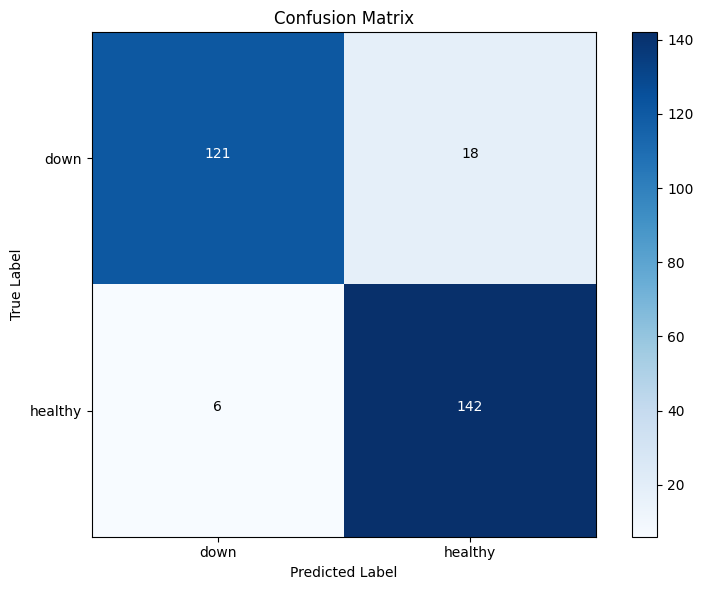


Found 24 misclassified images


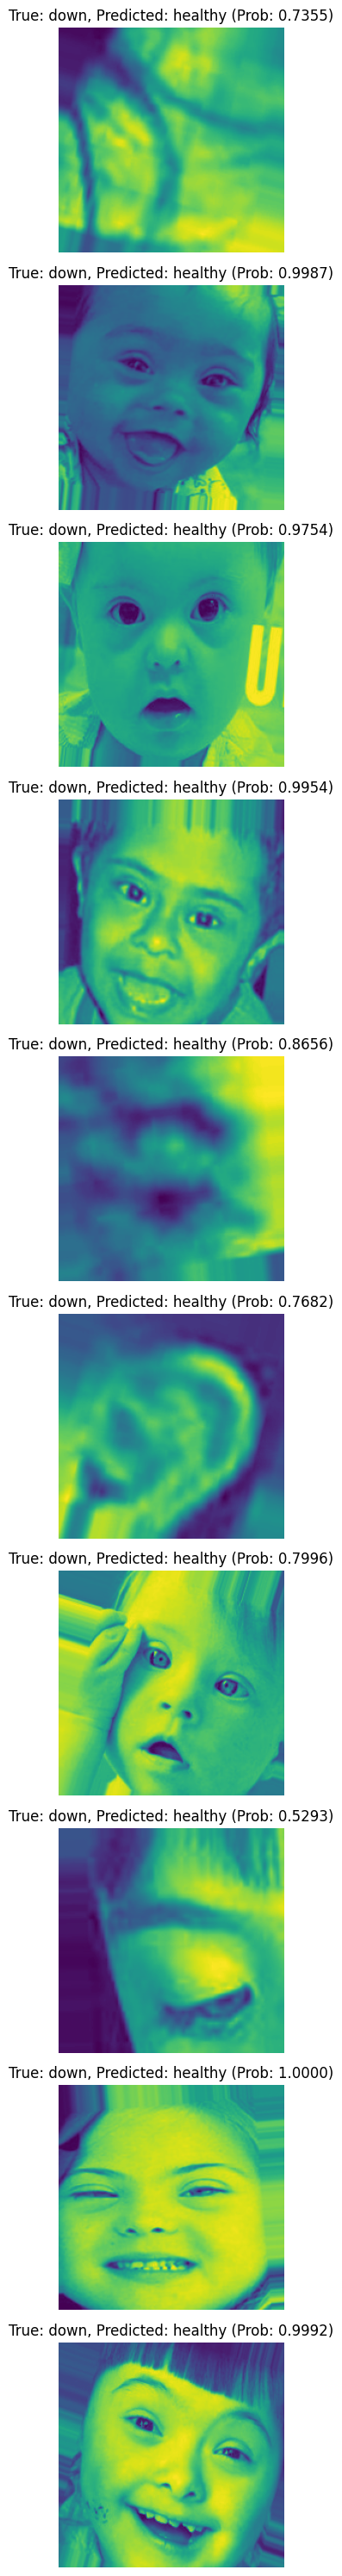

Saved misclassified images information to /content/drive/My Drive/capstone_dataset/misclassified_images.csv


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import os
import joblib

# Define paths
base_path = "/content/drive/My Drive/capstone_dataset"
model_path = os.path.join(base_path, "models", "down_syndrome_classifier.joblib")
test_path = os.path.join(base_path, "split_dataset", "test")

# Load the base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Load the saved classifier
classifier = joblib.load(model_path)

# Setup data generator for test data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_dataset = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important to keep order for analysis
)

# Function to extract features and predict
def evaluate_on_test_dataset(base_model, classifier, test_dataset):
    print("Extracting features from test dataset...")

    # Get ground truth labels and filenames
    test_dataset.reset()  # Reset generator to start from beginning
    filenames = test_dataset.filenames
    true_labels = test_dataset.classes
    class_indices = {v: k for k, v in test_dataset.class_indices.items()}

    # Extract features and predict
    features = []
    steps = len(test_dataset)

    for i in range(steps):
        print(f"Processing batch {i+1}/{steps}...")
        images, _ = next(test_dataset)
        batch_features = base_model.predict(images)
        batch_features = batch_features.reshape(batch_features.shape[0], -1)
        features.append(batch_features)

    # Concatenate all batch features
    X_test = np.vstack(features[:steps])

    # Make predictions
    predictions = classifier.predict(X_test)
    probabilities = classifier.predict_proba(X_test)[:, 1]  # Probability of Down syndrome

    # Print overall metrics
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions,
                               target_names=[class_indices[0], class_indices[1]]))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(true_labels, predictions)
    print(cm)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [class_indices[0], class_indices[1]])
    plt.yticks(tick_marks, [class_indices[0], class_indices[1]])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

    # Find misclassified images
    misclassified_indices = np.where(predictions != true_labels)[0]
    misclassified_files = [filenames[i] for i in misclassified_indices]
    misclassified_true = [class_indices[true_labels[i]] for i in misclassified_indices]
    misclassified_pred = [class_indices[predictions[i]] for i in misclassified_indices]
    misclassified_prob = [probabilities[i] for i in misclassified_indices]

    print(f"\nFound {len(misclassified_indices)} misclassified images")

    # Display some misclassified images (up to 10)
    num_to_display = min(10, len(misclassified_indices))
    if num_to_display > 0:
        plt.figure(figsize=(15, num_to_display * 3))
        for i in range(num_to_display):
            img_path = os.path.join(test_path, misclassified_files[i])
            img = plt.imread(img_path)
            plt.subplot(num_to_display, 1, i+1)
            plt.imshow(img)
            plt.title(f"True: {misclassified_true[i]}, Predicted: {misclassified_pred[i]} (Prob: {misclassified_prob[i]:.4f})")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    return misclassified_files, misclassified_true, misclassified_pred, misclassified_prob

# Run the evaluation
misclassified_files, misclassified_true, misclassified_pred, misclassified_prob = evaluate_on_test_dataset(base_model, classifier, test_dataset)

# Save the misclassified images information to a CSV file
import pandas as pd

if len(misclassified_files) > 0:
    misclassified_df = pd.DataFrame({
        'Filename': misclassified_files,
        'True_Label': misclassified_true,
        'Predicted_Label': misclassified_pred,
        'Confidence': misclassified_prob
    })

    csv_path = os.path.join(base_path, "misclassified_images.csv")
    misclassified_df.to_csv(csv_path, index=False)
    print(f"Saved misclassified images information to {csv_path}")

for reference preprocessing

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Define paths correctly
base_path = "/content/drive/My Drive/capstone_dataset"
split_dataset_path = os.path.join(base_path, "split_dataset")

train_path = os.path.join(split_dataset_path, "train")
val_path = os.path.join(split_dataset_path, "val")
test_path = os.path.join(split_dataset_path, "test")

# Data preprocessing
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_dataset = train_datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_dataset = val_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_dataset = test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Build the model using MobileNetV2 as a feature extractor
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20
)

# Evaluate the model
print("Evaluating on Test Data...")
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate predictions
y_pred = (model.predict(test_dataset) > 0.5).astype('int32').flatten()
y_true = test_dataset.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["No Down Syndrome", "Down Syndrome"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Save the model
model_save_path = os.path.join(base_path, "models", "down_syndrome_classifier.h5")
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save(model_save_path)
print(f"Model saved at {model_save_path}")

# Load and Test the Model
print("\nLoading the saved model...")
saved_model = tf.keras.models.load_model(model_save_path)

print("Predicting on test data...")
saved_predictions = (saved_model.predict(test_dataset) > 0.5).astype('int32').flatten()

print("\nClassification Report (Saved Model):")
print(classification_report(y_true, saved_predictions, target_names=["No Down Syndrome", "Down Syndrome"]))

print("\nConfusion Matrix (Saved Model):")
print(confusion_matrix(y_true, saved_predictions))


Found 1327 images belonging to 2 classes.
Found 283 images belonging to 2 classes.
Found 287 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7956 - loss: 0.5682 - val_accuracy: 0.8445 - val_loss: 0.3498
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9429 - loss: 0.1530 - val_accuracy: 0.8975 - val_loss: 0.2264
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9802 - loss: 0.0666 - val_accuracy: 0.9258 - val_loss: 0.1723
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9883 - loss: 0.0385 - val_accuracy: 0.9258 - val_loss: 0.1497
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9846 - loss: 0.0478 - val_accuracy: 0.9329 - val_loss: 0.1702
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9991 - loss: 0.0164 - val_accuracy: 0.9223 - val_loss: 0.1796
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9949 - loss: 0.0274 - val_accuracy: 0.9293 - val_loss: 0.2025
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9962 - loss: 0.0148 - val_accuracy: 0.9329 - val_loss:


Classification Report:
                  precision    recall  f1-score   support

No Down Syndrome       0.94      0.84      0.89       139
   Down Syndrome       0.86      0.95      0.90       148

        accuracy                           0.90       287
       macro avg       0.90      0.89      0.89       287
    weighted avg       0.90      0.90      0.90       287


Confusion Matrix:
[[117  22]
 [  8 140]]
Model saved at /content/drive/My Drive/capstone_dataset/models/down_syndrome_classifier.h5

Loading the saved model...


Predicting on test data...
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step

Classification Report (Saved Model):
                  precision    recall  f1-score   support

No Down Syndrome       0.94      0.84      0.89       139
   Down Syndrome       0.86      0.95      0.90       148

        accuracy                           0.90       287
       macro avg       0.90      0.89      0.89       287
    weighted avg       0.90      0.90      0.90       287


Confusion Matrix (Saved Model):
[[117  22]
 [  8 140]]
